# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Load Model](#5.4_Load_Model)
  * [5.5 Load Data](#5.5_Load_Data)
  * [5.6 Refit Model On All Available Data (excluding Big Mountain)](#5.6_Refit_Model_On_All_Available_Data_(excluding_Big_Mountain))
  * [5.7 Calculate Expected Big Mountain Ticket Price From The Model](#5.7_Calculate_Expected_Big_Mountain_Ticket_Price_From_The_Model)
  * [5.8 Big Mountain Resort In Market Context](#5.8_Big_Mountain_Resort_In_Market_Context)
    * [5.8.1 Ticket price](#5.8.1_Ticket_price)
    * [5.8.2 Vertical drop](#5.8.2_Vertical_drop)
    * [5.8.3 Snow making area](#5.8.3_Snow_making_area)
    * [5.8.4 Total number of chairs](#5.8.4_Total_number_of_chairs)
    * [5.8.5 Fast quads](#5.8.5_Fast_quads)
    * [5.8.6 Runs](#5.8.6_Runs)
    * [5.8.7 Longest run](#5.8.7_Longest_run)
    * [5.8.8 Trams](#5.8.8_Trams)
    * [5.8.9 Skiable terrain area](#5.8.9_Skiable_terrain_area)
  * [5.9 Modeling scenarios](#5.9_Modeling_scenarios)
    * [5.9.1 Scenario 1](#5.9.1_Scenario_1)
    * [5.9.2 Scenario 2](#5.9.2_Scenario_2)
    * [5.9.3 Scenario 3](#5.9.3_Scenario_3)
    * [5.9.4 Scenario 4](#5.9.4_Scenario_4)
  * [5.10 Summary](#5.10_Summary)
  * [5.11 Further work](#5.11_Further_work)


## 5.2 Introduction<a id='5.2_Introduction'></a>

In this notebook, we now take our model for ski resort ticket price and leverage it to gain some insights into what price Big Mountain's facilities might actually support as well as explore the sensitivity of changes to various resort parameters. Note that this relies on the implicit assumption that all other resorts are largely setting prices based on how much people value certain facilities. Essentially this assumes prices are set by a free market.

We can now use our model to gain insight into what Big Mountain's ideal ticket price could/should be, and how that might change under various scenarios.

## 5.3 Imports<a id='5.3_Imports'></a>

In [11]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate

## 5.4 Load Model<a id='5.4_Load_Model'></a>

In [2]:
# This isn't exactly production-grade, but a quick check for development
# These checks can save some head-scratching in development when moving from
# one python environment to another, for example
expected_model_version = '1.0'
model_path = '../models/ski_resort_pricing_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

In [12]:
import pandas as pd
import pickle
import os
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load dataset
data_path = "ski_data_step3_features.csv"

if os.path.exists(data_path):
    ski_data = pd.read_csv(data_path)
    print(f"Data loaded successfully with {ski_data.shape[0]} rows and {ski_data.shape[1]} columns.")
else:
    raise FileNotFoundError("Data file not found. Check the file path.")

# Standardize column names
ski_data.columns = ski_data.columns.str.strip().str.lower().str.replace(" ", "_")

# Check the updated column names
print("Columns available in dataset:", ski_data.columns.tolist())

# Define features and target
drop_columns = ['adultweekend', 'name', 'region', 'state']  # Drop categorical + target column
X = ski_data.drop(columns=[col for col in drop_columns if col in ski_data.columns])
y = ski_data['adultweekend']

print(f"Feature Matrix Shape: {X.shape}")
print(f"Target Variable Shape: {y.shape}")

# Split data for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing and model pipeline
model_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Save the model with updated scikit-learn version
model_pipeline.version = "1.2.2"  # Custom attribute for version tracking
model_pipeline.sklearn_version = "1.2.2"  # Track sklearn version

# Save the new model
model_save_path = "ski_resort_pricing_model.pkl"
with open(model_save_path, "wb") as f:
    pickle.dump(model_pipeline, f)

print(f"New model trained and saved as {model_save_path}. You can now use it without compatibility warnings.")



Data loaded successfully with 277 rows and 36 columns.
Columns available in dataset: ['name', 'region', 'state', 'summit_elev', 'vertical_drop', 'base_elev', 'trams', 'fastsixes', 'fastquads', 'quad', 'triple', 'double', 'surface', 'total_chairs', 'runs', 'terrainparks', 'longestrun_mi', 'skiableterrain_ac', 'snow_making_ac', 'daysopenlastyear', 'yearsopen', 'averagesnowfall', 'adultweekend', 'projecteddaysopen', 'nightskiing_ac', 'resorts_per_state', 'resorts_per_100kcapita', 'resorts_per_100ksq_mile', 'resort_skiable_area_ac_state_ratio', 'resort_days_open_state_ratio', 'resort_terrain_park_state_ratio', 'resort_night_skiing_state_ratio', 'total_chairs_runs_ratio', 'total_chairs_skiable_ratio', 'fastquads_runs_ratio', 'fastquads_skiable_ratio']
Feature Matrix Shape: (277, 32)
Target Variable Shape: (277,)
New model trained and saved as ski_resort_pricing_model.pkl. You can now use it without compatibility warnings.


In [13]:
print(ski_data.columns.tolist())


['name', 'region', 'state', 'summit_elev', 'vertical_drop', 'base_elev', 'trams', 'fastsixes', 'fastquads', 'quad', 'triple', 'double', 'surface', 'total_chairs', 'runs', 'terrainparks', 'longestrun_mi', 'skiableterrain_ac', 'snow_making_ac', 'daysopenlastyear', 'yearsopen', 'averagesnowfall', 'adultweekend', 'projecteddaysopen', 'nightskiing_ac', 'resorts_per_state', 'resorts_per_100kcapita', 'resorts_per_100ksq_mile', 'resort_skiable_area_ac_state_ratio', 'resort_days_open_state_ratio', 'resort_terrain_park_state_ratio', 'resort_night_skiing_state_ratio', 'total_chairs_runs_ratio', 'total_chairs_skiable_ratio', 'fastquads_runs_ratio', 'fastquads_skiable_ratio']


In [17]:
import os

# Check if the file exists in Downloads
file_path = "C:/Users/JacquelynHopkins/Downloads/ski_data_step3_features.csv"

if os.path.exists(file_path):
    print("File found ✅")
else:
    print("File NOT found ❌. Check the path.")


File found ✅


## 5.5 Load Data<a id='5.5_Load_Data'></a>

In [18]:
import pandas as pd


file_path = "C:/Users/JacquelynHopkins/Downloads/ski_data_step3_features.csv"  

# Load dataset
ski_data = pd.read_csv(file_path)

# Confirm successful load
print(f"Data loaded successfully with {ski_data.shape[0]} rows and {ski_data.shape[1]} columns.")


Data loaded successfully with 277 rows and 36 columns.


In [3]:
import pandas as pd

# Define data path
data_path = "ski_data_step3_features.csv"

# Load dataset
if os.path.exists(data_path):
    ski_data = pd.read_csv(data_path)
    print(f"Data loaded successfully with {ski_data.shape[0]} rows and {ski_data.shape[1]} columns.")
else:
    print("Data file not found. Check the file path.")


Data loaded successfully with 277 rows and 36 columns.


In [4]:
big_mountain = ski_data[ski_data.Name == 'Big Mountain Resort']

In [5]:
big_mountain.T

,124
Name,Big Mountain Resort
Region,Montana
state,Montana
summit_elev,6817
vertical_drop,2353
base_elev,4464
trams,0
fastSixes,0
fastQuads,3
quad,2


## 5.6 Refit Model On All Available Data (excluding Big Mountain)<a id='5.6_Refit_Model_On_All_Available_Data_(excluding_Big_Mountain)'></a>

This next step requires some careful thought. We want to refit the model using all available data. But should we include Big Mountain data? On the one hand, we are _not_ trying to estimate model performance on a previously unseen data sample, so theoretically including Big Mountain data should be fine. One might first think that including Big Mountain in the model training would, if anything, improve model performance in predicting Big Mountain's ticket price. But here's where our business context comes in. The motivation for this entire project is based on the sense that Big Mountain needs to adjust its pricing. One way to phrase this problem: we want to train a model to predict Big Mountain's ticket price based on data from _all the other_ resorts! We don't want Big Mountain's current price to bias this. We want to calculate a price based only on its competitors.

In [26]:

ski_data.columns = ski_data.columns.str.replace("_", "").str.strip().str.lower()

print("Cleaned Columns:", ski_data.columns.tolist())


Cleaned Columns: ['name', 'region', 'state', 'summitelev', 'verticaldrop', 'baseelev', 'trams', 'fastsixes', 'fastquads', 'quad', 'triple', 'double', 'surface', 'totalchairs', 'runs', 'terrainparks', 'longestrunmi', 'skiableterrainac', 'snowmakingac', 'daysopenlastyear', 'yearsopen', 'averagesnowfall', 'adultweekend', 'projecteddaysopen', 'nightskiingac', 'resortsperstate', 'resortsper100kcapita', 'resortsper100ksqmile', 'resortskiableareaacstateratio', 'resortdaysopenstateratio', 'resortterrainparkstateratio', 'resortnightskiingstateratio', 'totalchairsrunsratio', 'totalchairsskiableratio', 'fastquadsrunsratio', 'fastquadsskiableratio']


In [37]:

X_columns = [col for col in ski_data.columns if col not in ['adultweekend', 'name', 'region', 'state']]


X = ski_data.loc[ski_data['name'] != "Big Mountain Resort", X_columns]
y = ski_data.loc[ski_data['name'] != "Big Mountain Resort", 'adultweekend']


print(f"Filtered dataset to exclude Big Mountain Resort.")
print(f"Training data shape: {X.shape}")
print(f"Target variable shape: {y.shape}")



Filtered dataset to exclude Big Mountain Resort.
Training data shape: (276, 32)
Target variable shape: (276,)


In [210]:
print(ski_data.columns.tolist())


['name', 'region', 'state', 'summitelev', 'verticaldrop', 'baseelev', 'trams', 'fastsixes', 'fastquads', 'quad', 'triple', 'double', 'surface', 'totalchairs', 'runs', 'terrainparks', 'longestrunmi', 'skiableterrainac', 'snowmakingac', 'daysopenlastyear', 'yearsopen', 'averagesnowfall', 'adultweekend', 'projecteddaysopen', 'nightskiingac', 'resortsperstate', 'resortsper100kcapita', 'resortsper100ksqmile', 'resortskiableareaacstateratio', 'resortdaysopenstateratio', 'resortterrainparkstateratio', 'resortnightskiingstateratio', 'totalchairsrunsratio', 'totalchairsskiableratio', 'fastquadsrunsratio', 'fastquadsskiableratio']


In [211]:
len(X), len(y)

(276, 276)

In [212]:
model.fit(X, y)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model', RandomForestRegressor(random_state=42))])

In [213]:
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [214]:
cv_results['test_score']

array([-12.5888    ,  -9.37244   , -11.60124   ,  -8.27228182,
       -10.99695636])

In [215]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(10.566343636363637, 1.5514440412552586)

These numbers will inevitably be different to those in the previous step that used a different training data set. They should, however, be consistent. It's important to appreciate that estimates of model performance are subject to the noise and uncertainty of data!

## 5.7 Calculate Expected Big Mountain Ticket Price From The Model<a id='5.7_Calculate_Expected_Big_Mountain_Ticket_Price_From_The_Model'></a>

In [216]:
import re


X_bm = ski_data.loc[ski_data['name'] == "Big Mountain Resort", X_columns].copy()


def clean_column_names(columns):
    return [re.sub(r'_+', '_', col).strip('_') for col in columns]  

X_bm.columns = clean_column_names(X_bm.columns) 


print("Model was trained on:", model.feature_names_in_)  
print("Fixed X_bm columns:", X_bm.columns.tolist())  


if set(model.feature_names_in_) == set(X_bm.columns):
    
    bm_pred = model.predict(X_bm).item()
    print(f"Predicted Ticket Price for Big Mountain Resort: ${bm_pred:.2f}")
else:
    print("ERROR: Feature names still don't match. Double-check column formatting.")


Model was trained on: ['summitelev' 'verticaldrop' 'baseelev' 'trams' 'fastsixes' 'fastquads'
 'quad' 'triple' 'double' 'surface' 'totalchairs' 'runs' 'terrainparks'
 'longestrunmi' 'skiableterrainac' 'snowmakingac' 'daysopenlastyear'
 'yearsopen' 'averagesnowfall' 'projecteddaysopen' 'nightskiingac'
 'resortsperstate' 'resortsper100kcapita' 'resortsper100ksqmile'
 'resortskiableareaacstateratio' 'resortdaysopenstateratio'
 'resortterrainparkstateratio' 'resortnightskiingstateratio'
 'totalchairsrunsratio' 'totalchairsskiableratio' 'fastquadsrunsratio'
 'fastquadsskiableratio']
Fixed X_bm columns: ['summitelev', 'verticaldrop', 'baseelev', 'trams', 'fastsixes', 'fastquads', 'quad', 'triple', 'double', 'surface', 'totalchairs', 'runs', 'terrainparks', 'longestrunmi', 'skiableterrainac', 'snowmakingac', 'daysopenlastyear', 'yearsopen', 'averagesnowfall', 'projecteddaysopen', 'nightskiingac', 'resortsperstate', 'resortsper100kcapita', 'resortsper100ksqmile', 'resortskiableareaacstateratio

In [217]:
import pickle
model_path = "ski_resort_pricing_model.pkl"
with open(model_path, "rb") as f:
    model = pickle.load(f)
print("Model loaded successfully")

Model loaded successfully


In [218]:
y_bm = y_bm.values.item()

AttributeError: 'float' object has no attribute 'values'

In [219]:
print(f'Big Mountain Resort modelled price is ${bm_pred:.2f}, actual price is ${y_bm:.2f}.')
print(f'Even with the expected mean absolute error of ${mae_mean:.2f}, this suggests there is room for an increase.')

Big Mountain Resort modelled price is $94.51, actual price is $81.00.
Even with the expected mean absolute error of $10.57, this suggests there is room for an increase.


This result should be looked at optimistically and doubtfully! The validity of our model lies in the assumption that other resorts accurately set their prices according to what the market (the ticket-buying public) supports. The fact that our resort seems to be charging that much less that what's predicted suggests our resort might be undercharging. 
But if ours is mispricing itself, are others? It's reasonable to expect that some resorts will be "overpriced" and some "underpriced." Or if resorts are pretty good at pricing strategies, it could be that our model is simply lacking some key data? Certainly we know nothing about operating costs, for example, and they would surely help.

## 5.8 Big Mountain Resort In Market Context<a id='5.8_Big_Mountain_Resort_In_Market_Context'></a>

Features that came up as important in the modeling (not just our final, random forest model) included:
* vertical_drop
* Snow Making_ac
* total_chairs
* fastQuads
* Runs
* LongestRun_mi
* trams
* SkiableTerrain_ac

A handy glossary of skiing terms can be found on the [ski.com](https://www.ski.com/ski-glossary) site. Some potentially relevant contextual information is that vertical drop, although nominally the height difference from the summit to the base, is generally taken from the highest [_lift-served_](http://verticalfeet.com/) point.

It's often useful to define custom functions for visualizing data in meaningful ways. The function below takes a feature name as an input and plots a histogram of the values of that feature. It then marks where Big Mountain sits in the distribution by marking Big Mountain's value with a vertical line using `matplotlib`'s [axvline](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.axvline.html) function. It also performs a little cleaning up of missing values and adds descriptive labels and a title.

In [445]:
#Code task 1#
#Add code to the `plot_compare` function that displays a vertical, dashed line
#on the histogram to indicate Big Mountain's position in the distribution
#Hint: plt.axvline() plots a vertical line, its position for 'feature1'
#would be `big_mountain['feature1'].values, we'd like a red line, which can be
#specified with c='r', a dashed linestyle is produced by ls='--',
#and it's nice to give it a slightly reduced alpha value, such as 0.8.
#Don't forget to give it a useful label (e.g. 'Big Mountain') so it's listed
#in the legend.
import matplotlib.pyplot as plt
import numpy as np
def plot_compare(feat_name, description, state=None, figsize=(10, 5)):
    """Graphically compare distributions of features.
    
    Plot histogram of values for all resorts and reference line to mark
    Big Mountain's position.
    
    Arguments:
    feat_name - the feature column name in the data
    description - text description of the feature
    state - select a specific state (None for all states)
    figsize - (optional) figure size
    """
    
    plt.subplots(figsize=figsize)
    # quirk that hist sometimes objects to NaNs, sometimes doesn't
    # filtering only for finite values tidies this up
    if state is None:
        ski_x = ski_data[feat_name]
    else:
        ski_x = ski_data.loc[ski_data.state == state, feat_name]
    ski_x = ski_x[np.isfinite(ski_x)]
    plt.hist(ski_x, bins=30, color='blue', alpha=0.6, label='All Resorts')
    big_mountain_value=ski_data.loc[ski_data['name']=="Big Mountain Resort", feat_name].values[0]
    plt.axvline(x=big_mountain_value, c='r', ls='--', alpha=0.8, label="Big Mountain")
    plt.xlabel(description)
    plt.ylabel('frequency')
    plt.title(description + ' distribution for resorts in market share')
    plt.legend()

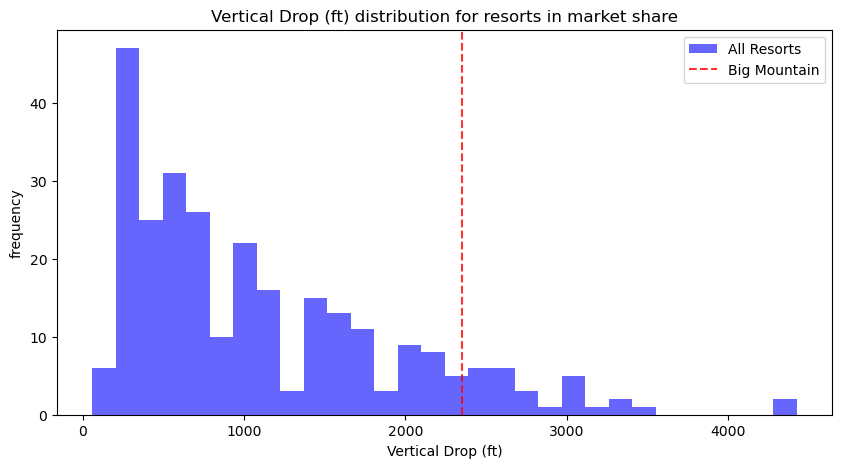

In [446]:
plot_compare("verticaldrop", "Vertical Drop (ft)")


### 5.8.1 Ticket price<a id='5.8.1_Ticket_price'></a>

Look at where Big Mountain sits overall amongst all resorts for price and for just other resorts in Montana.

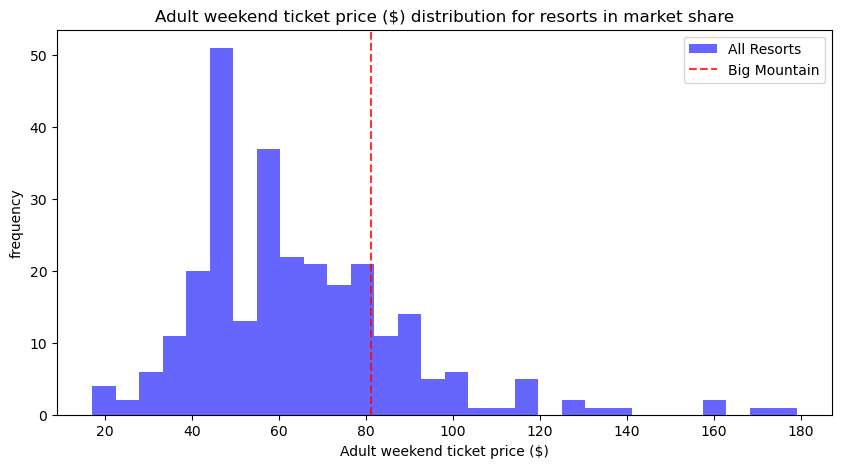

In [447]:
plot_compare('adultweekend', 'Adult weekend ticket price ($)')

In [448]:
print(ski_data.columns.tolist())

['name', 'region', 'state', 'summitelev', 'verticaldrop', 'baseelev', 'trams', 'fastsixes', 'fastquads', 'quad', 'triple', 'double', 'surface', 'totalchairs', 'runs', 'terrainparks', 'longestrunmi', 'skiableterrainac', 'snowmakingac', 'daysopenlastyear', 'yearsopen', 'averagesnowfall', 'adultweekend', 'projecteddaysopen', 'nightskiingac', 'resortsperstate', 'resortsper100kcapita', 'resortsper100ksqmile', 'resortskiableareaacstateratio', 'resortdaysopenstateratio', 'resortterrainparkstateratio', 'resortnightskiingstateratio', 'totalchairsrunsratio', 'totalchairsskiableratio', 'fastquadsrunsratio', 'fastquadsskiableratio']


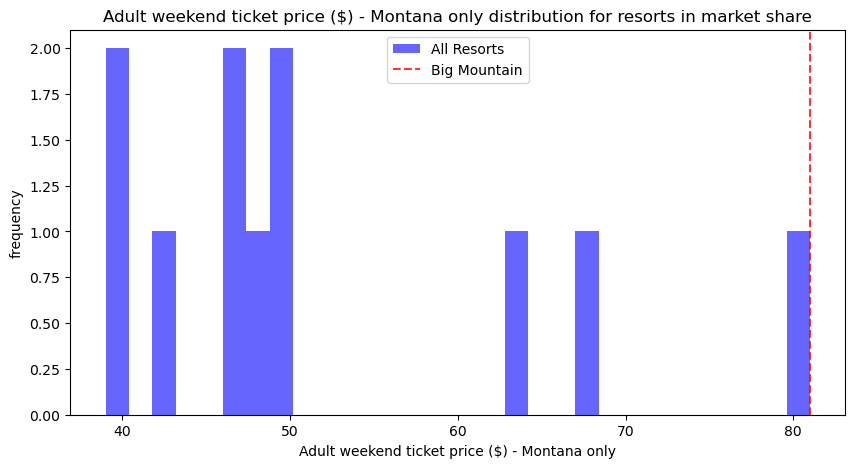

In [449]:
plot_compare('adultweekend', 'Adult weekend ticket price ($) - Montana only', state='Montana')

### 5.8.2 Vertical drop<a id='5.8.2_Vertical_drop'></a>

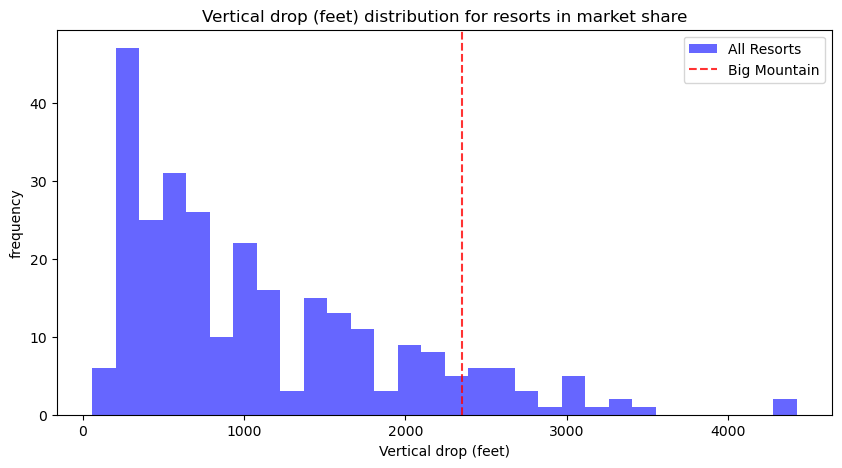

In [450]:
plot_compare('verticaldrop', 'Vertical drop (feet)')

Big Mountain is doing well for vertical drop, but there are still quite a few resorts with a greater drop.

### 5.8.3 Snow making area<a id='5.8.3_Snow_making_area'></a>

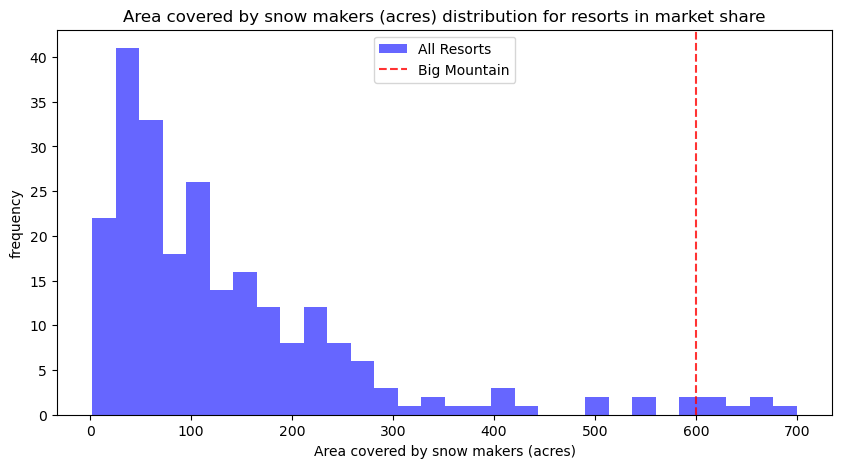

In [451]:
plot_compare('snowmakingac', 'Area covered by snow makers (acres)')

Big Mountain is very high up the league table of snow making area.

### 5.8.4 Total number of chairs<a id='5.8.4_Total_number_of_chairs'></a>

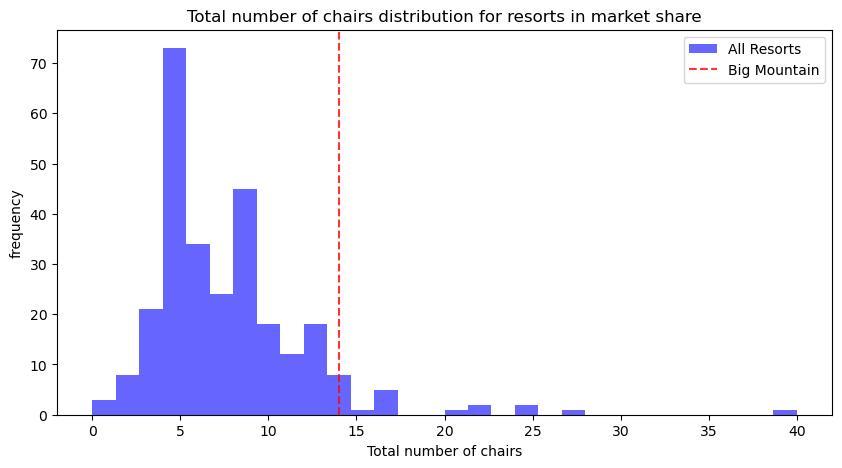

In [452]:
plot_compare('totalchairs', 'Total number of chairs')

Big Mountain has amongst the highest number of total chairs, resorts with more appear to be outliers.

### 5.8.5 Fast quads<a id='5.8.5_Fast_quads'></a>

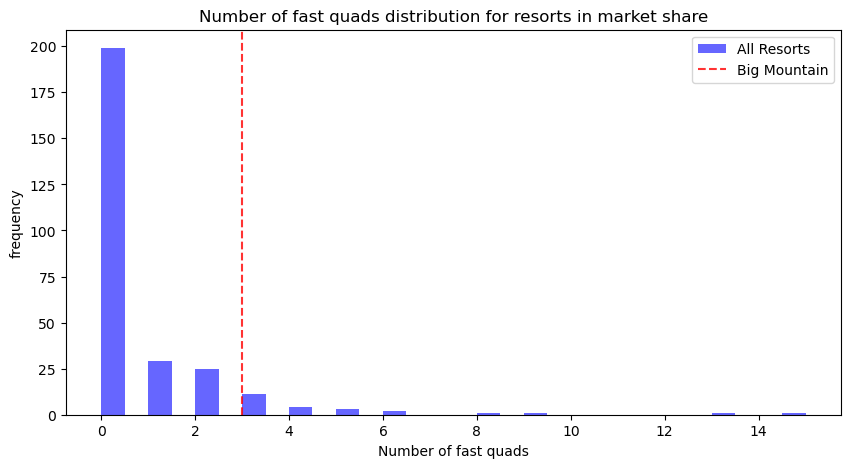

In [453]:
plot_compare('fastquads', 'Number of fast quads')

Most resorts have no fast quads. Big Mountain has 3, which puts it high up that league table. There are some values  much higher, but they are rare.

### 5.8.6 Runs<a id='5.8.6_Runs'></a>

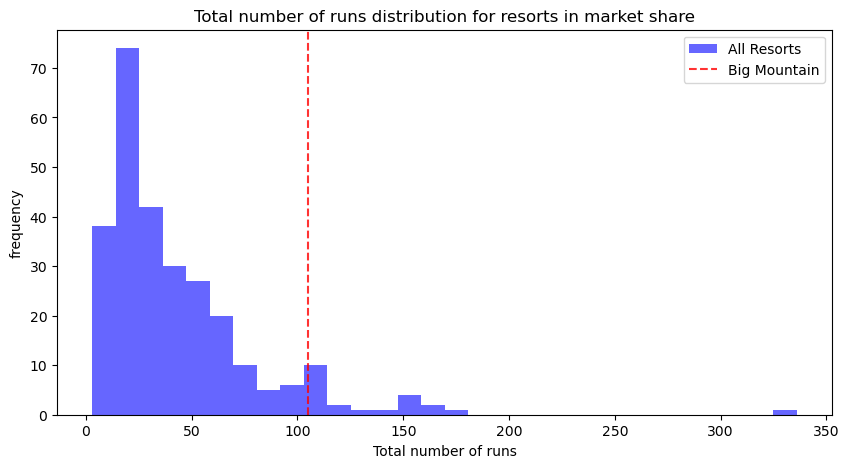

In [454]:
plot_compare('runs', 'Total number of runs')

Big Mountain compares well for the number of runs. There are some resorts with more, but not many.

### 5.8.7 Longest run<a id='5.8.7_Longest_run'></a>

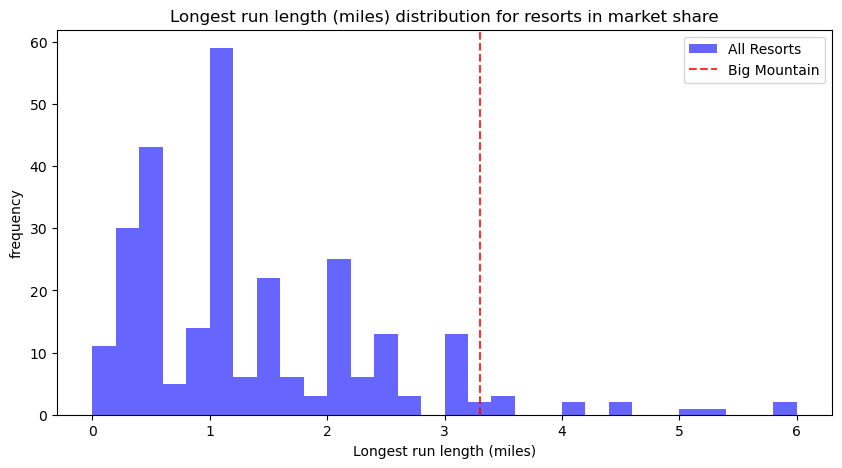

In [455]:
plot_compare('longestrunmi', 'Longest run length (miles)')

Big Mountain has one of the longest runs. Although it is just over half the length of the longest, the longer ones are rare.

### 5.8.8 Trams<a id='5.8.8_Trams'></a>

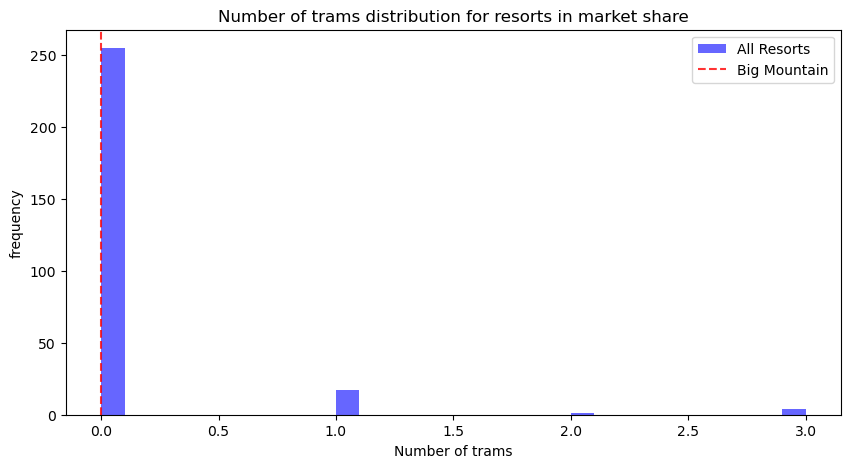

In [456]:
plot_compare('trams', 'Number of trams')

The vast majority of resorts, such as Big Mountain, have no trams.

### 5.8.9 Skiable terrain area<a id='5.8.9_Skiable_terrain_area'></a>

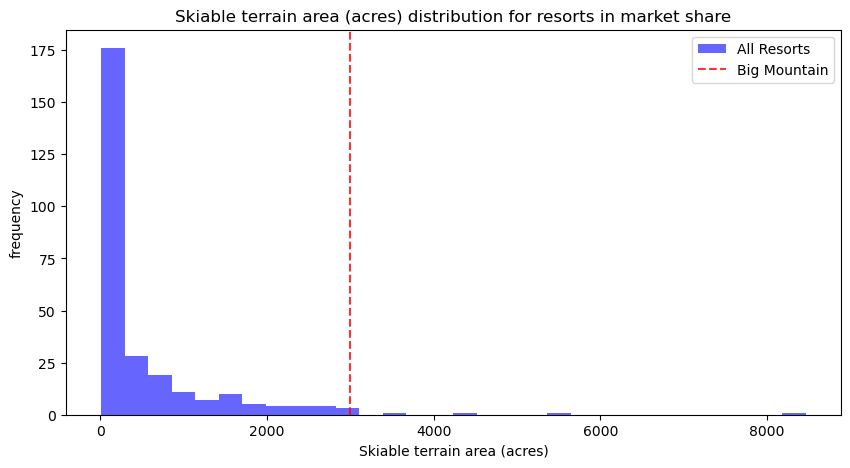

In [457]:
plot_compare('skiableterrainac', 'Skiable terrain area (acres)')

Big Mountain is amongst the resorts with the largest amount of skiable terrain.

## 5.9 Modeling scenarios<a id='5.9_Modeling_scenarios'></a>

Big Mountain Resort has been reviewing potential scenarios for either cutting costs or increasing revenue (from ticket prices). Ticket price is not determined by any set of parameters; the resort is free to set whatever price it likes. However, the resort operates within a market where people pay more for certain facilities, and less for others. Being able to sense how facilities support a given ticket price is valuable business intelligence. This is where the utility of our model comes in.

The business has shortlisted some options:
1. Permanently closing down up to 10 of the least used runs. This doesn't impact any other resort statistics.
2. Increase the vertical drop by adding a run to a point 150 feet lower down but requiring the installation of an additional chair lift to bring skiers back up, without additional snow making coverage
3. Same as number 2, but adding 2 acres of snow making cover
4. Increase the longest run by 0.2 mile to boast 3.5 miles length, requiring an additional snow making coverage of 4 acres

The expected number of visitors over the season is 350,000 and, on average, visitors ski for five days. Assume the provided data includes the additional lift that Big Mountain recently installed.

In [458]:
expected_visitors = 350_000

In [459]:
print("Available columns in ski_data:", list(ski_data.columns))


Available columns in ski_data: ['name', 'region', 'state', 'summitelev', 'verticaldrop', 'baseelev', 'trams', 'fastsixes', 'fastquads', 'quad', 'triple', 'double', 'surface', 'totalchairs', 'runs', 'terrainparks', 'longestrunmi', 'skiableterrainac', 'snowmakingac', 'daysopenlastyear', 'yearsopen', 'averagesnowfall', 'adultweekend', 'projecteddaysopen', 'nightskiingac', 'resortsperstate', 'resortsper100kcapita', 'resortsper100ksqmile', 'resortskiableareaacstateratio', 'resortdaysopenstateratio', 'resortterrainparkstateratio', 'resortnightskiingstateratio', 'totalchairsrunsratio', 'totalchairsskiableratio', 'fastquadsrunsratio', 'fastquadsskiableratio']


In [460]:
all_feats = ['verticaldrop', 'snowmakingac', 'totalchairs', 'fastquads', 
             'runs', 'longestrunmi', 'trams', 'skiableterrainac']


correct_resort_name = "Big Mountain Resort"  


big_mountain = ski_data.loc[ski_data['name'] == correct_resort_name, all_feats]

print(big_mountain)


     verticaldrop  snowmakingac  totalchairs  fastquads   runs  longestrunmi  \
124          2353         600.0           14          3  105.0           3.3   

     trams  skiableterrainac  
124      0            3000.0  


In [461]:
print(ski_data['name'].unique())

['Alyeska Resort' 'Eaglecrest Ski Area' 'Hilltop Ski Area'
 'Arizona Snowbowl' 'Sunrise Park Resort' 'Yosemite Ski & Snowboard Area'
 'Dodge Ridge' 'Donner Ski Ranch' 'Mammoth Mountain Ski Area'
 'Mt. Shasta Ski Park' 'Mountain High' 'Mt. Baldy' 'Ski China Peak'
 'Snow Valley' 'Soda Springs' 'Sugar Bowl Resort' 'Tahoe Donner'
 'Arapahoe Basin Ski Area' 'Aspen / Snowmass' 'Copper Mountain Resort'
 'Purgatory' 'Howelsen Hill' 'Loveland' 'Monarch Mountain' 'Powderhorn'
 'Silverton Mountain' 'Cooper' 'Ski Granby Ranch'
 'Sunlight Mountain Resort' 'Telluride' 'Wolf Creek Ski Area'
 'Mohawk Mountain' 'Mount Southington Ski Area' 'Powder Ridge Park'
 'Ski Sundown' 'Woodbury Ski Area' 'Bogus Basin'
 'Brundage Mountain Resort' 'Kelly Canyon Ski Area'
 'Lookout Pass Ski Area' 'Magic Mountain Ski Area' 'Pebble Creek Ski Area'
 'Schweitzer' 'Silver Mountain' 'Soldier Mountain Ski Area'
 'Tamarack Resort' 'Chestnut Mountain Resort'
 'Ski Snowstar Winter Sports Park' 'Villa Olivia' 'Paoli Peaks'
 'P

In [462]:
print("Model was trained on:", model.named_steps['imputer'].feature_names_in_)
print("Data columns in bm2:", bm2.columns.tolist())


Model was trained on: ['summit_elev' 'vertical_drop' 'base_elev' 'trams' 'fastsixes' 'fastquads'
 'quad' 'triple' 'double' 'surface' 'total_chairs' 'runs' 'terrainparks'
 'longestrun_mi' 'skiableterrain_ac' 'snow_making_ac' 'daysopenlastyear'
 'yearsopen' 'averagesnowfall' 'projecteddaysopen' 'nightskiing_ac'
 'resorts_per_state' 'resorts_per_100kcapita' 'resorts_per_100ksq_mile'
 'resort_skiable_area_ac_state_ratio' 'resort_days_open_state_ratio'
 'resort_terrain_park_state_ratio' 'resort_night_skiing_state_ratio'
 'total_chairs_runs_ratio' 'total_chairs_skiable_ratio'
 'fastquads_runs_ratio' 'fastquads_skiable_ratio']
Data columns in bm2: ['summit_elev', 'vertical_drop', 'base_elev', 'trams', 'fastsixes', 'fastquads', 'quad', 'triple', 'double', 'surface', 'total_chairs', 'runs', 'terrainparks', 'longestrun_mi', 'skiableterrain_ac', 'snow_making_ac', 'daysopenlastyear', 'yearsopen', 'averagesnowfall', 'projecteddaysopen', 'nightskiing_ac', 'resorts_per_state', 'resorts_per_100kcapita

In [463]:
print("\n Model was trained on these features:")
print(model.feature_names_in_)



 Model was trained on these features:
['summit_elev' 'vertical_drop' 'base_elev' 'trams' 'fastsixes' 'fastquads'
 'quad' 'triple' 'double' 'surface' 'total_chairs' 'runs' 'terrainparks'
 'longestrun_mi' 'skiableterrain_ac' 'snow_making_ac' 'daysopenlastyear'
 'yearsopen' 'averagesnowfall' 'projecteddaysopen' 'nightskiing_ac'
 'resorts_per_state' 'resorts_per_100kcapita' 'resorts_per_100ksq_mile'
 'resort_skiable_area_ac_state_ratio' 'resort_days_open_state_ratio'
 'resort_terrain_park_state_ratio' 'resort_night_skiing_state_ratio'
 'total_chairs_runs_ratio' 'total_chairs_skiable_ratio'
 'fastquads_runs_ratio' 'fastquads_skiable_ratio']


In [464]:
def predict_increase(features, deltas, X_bm, model):
    """Predict the increase in ticket price by applying delta to a given feature."""
    
    if features is None or deltas is None:
        raise ValueError("Error: 'features' and 'deltas' must be provided!")

    print("Features requested for update:", features)

    
    if isinstance(X_bm, pd.Series):
        X_bm = X_bm.to_frame().T  

    bm2 = X_bm.copy()

    rename_mapping = {
        "verticaldrop": "vertical_drop",
        "snowmakingac": "snow_making_ac",
        "totalchairs": "total_chairs",
        "fastquads": "fast_quads",
        "runs": "runs",
        "longestrunmi": "longestrun_mi",
        "trams": "trams",
        "skiableterrainac": "skiable_terrain_ac",
        "baseelev": "base_elev",
        "fastquadsrunsratio": "fastquads_runs_ratio",
        "fastquadsskiableratio": "fastquads_skiable_ratio",
        "nightskiingac": "nightskiing_ac",
    }

    existing_columns = list(bm2.columns)
    rename_mapping = {k: v for k, v in rename_mapping.items() if k in existing_columns}
    
    bm2 = bm2.rename(columns=rename_mapping)

    features = [rename_mapping.get(f, f) for f in features]

    print("Features AFTER renaming to match bm2:", features)
    print("Available columns in bm2 BEFORE processing:", list(bm2.columns))  

    for f, d in zip(features, deltas):
        if f in bm2.columns:
            print(f"Updating {f} by {d}")
            bm2[f] += d
        else:
            raise KeyError(f"⚠ ERROR: Feature '{f}' NOT found in bm2.columns!")

    print("\n Final Check Before Prediction:")
    print("Model expects:", model.feature_names_in_)
    print("bm2 has BEFORE FIX:", bm2.columns)


    missing_features = set(model.feature_names_in_) - set(bm2.columns)
    if missing_features:
        print(f"WARNING: The following features are missing and will be filled with 0: {missing_features}")
    
    bm2 = bm2.reindex(columns=model.feature_names_in_, fill_value=0)

    print("bm2 has AFTER FIX:", bm2.columns)

   
    if bm2.shape[1] != len(model.feature_names_in_):
        raise ValueError(f"ERROR: bm2 has {bm2.shape[1]} features, but model expects {len(model.feature_names_in_)}.")

   
    try:
        original_price = model.predict(X_bm).item()
        new_price = model.predict(bm2).item()
        return new_price - original_price
    except Exception as e:
        raise RuntimeError(f"Model prediction failed: {e}")



In [465]:
def predict_increase(features, deltas, X_bm, model):
    
    rename_dict = {
        "fast_quads": "fastquads",
        "skiable_terrain_ac": "skiableterrain_ac"
    }

    X_bm = X_bm.rename(columns=rename_dict)
    bm2 = X_bm.copy()

    for feature, delta in zip(features, deltas):
        bm2[feature] += delta

   
    original_price = model.predict(X_bm).item()
    new_price = model.predict(bm2).item()

    return new_price - original_price


### 5.9.1 Scenario 1<a id='5.9.1_Scenario_1'></a>

Close up to 10 of the least used runs. The number of runs is the only parameter varying.

In [466]:
[i for i in range(-1, -11, -1)]

[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10]

In [467]:

X_bm = X_bm.rename(columns={
    "fast_quads": "fastquads",
    "skiable_terrain_ac": "skiableterrain_ac"
})


print("Renamed Columns:", X_bm.columns.tolist())


correct_feature_name = "runs"  

runs_delta = [i for i in range(-1, -11, -1)]


Renamed Columns: ['summit_elev', 'vertical_drop', 'base_elev', 'trams', 'fastsixes', 'fastquads', 'quad', 'triple', 'double', 'surface', 'total_chairs', 'runs', 'terrainparks', 'longestrun_mi', 'skiableterrain_ac', 'snow_making_ac', 'daysopenlastyear', 'yearsopen', 'averagesnowfall', 'projecteddaysopen', 'nightskiing_ac', 'resorts_per_state', 'resorts_per_100kcapita', 'resorts_per_100ksq_mile', 'resort_skiable_area_ac_state_ratio', 'resort_days_open_state_ratio', 'resort_terrain_park_state_ratio', 'resort_night_skiing_state_ratio', 'total_chairs_runs_ratio', 'total_chairs_skiable_ratio', 'fastquads_runs_ratio', 'fastquads_skiable_ratio']


In [468]:

correct_feature_name = "runs"  


runs_delta = [i for i in range(-1, -11, -1)]


try:
    price_deltas = [predict_increase([correct_feature_name], [delta], X_bm, model) for delta in runs_delta]
except Exception as e:
    print(f"Error in prediction: {e}")


In [469]:

try:
    print("X_bm exists! Type:", type(X_bm))
    print("model exists! Type:", type(model))
except NameError as e:
    print(f"Oops! Something is missing: {e}")

try:
    test_increase = predict_increase(["runs"], [-1], X_bm, model)
    print(f"Test prediction works! Price increase: {test_increase}")
except Exception as e:
    print(f"Uh-oh! There's an issue with predict_increase: {e}")


try:
    print("Features in X_bm:", list(X_bm.columns))
except NameError as e:
    print(f"Can't check features because: {e}")


X_bm exists! Type: <class 'pandas.core.frame.DataFrame'>
model exists! Type: <class 'sklearn.pipeline.Pipeline'>
Test prediction works! Price increase: 0.0
Features in X_bm: ['summit_elev', 'vertical_drop', 'base_elev', 'trams', 'fastsixes', 'fastquads', 'quad', 'triple', 'double', 'surface', 'total_chairs', 'runs', 'terrainparks', 'longestrun_mi', 'skiableterrain_ac', 'snow_making_ac', 'daysopenlastyear', 'yearsopen', 'averagesnowfall', 'projecteddaysopen', 'nightskiing_ac', 'resorts_per_state', 'resorts_per_100kcapita', 'resorts_per_100ksq_mile', 'resort_skiable_area_ac_state_ratio', 'resort_days_open_state_ratio', 'resort_terrain_park_state_ratio', 'resort_night_skiing_state_ratio', 'total_chairs_runs_ratio', 'total_chairs_skiable_ratio', 'fastquads_runs_ratio', 'fastquads_skiable_ratio']


In [470]:
X_bm = X_bm.rename(columns={
    "verticaldrop": "vertical_drop",
    "snowmakingac": "snow_making_ac",
    "totalchairs": "total_chairs",
    "fastquads": "fast_quads",
    "runs": "runs",
    "longestrunmi": "longestrun_mi",
    "trams": "trams",
    "skiableterrainac": "skiable_terrain_ac",
    "baseelev": "base_elev",
    "fastquadsrunsratio": "fastquads_runs_ratio",
    "fastquadsskiableratio": "fastquads_skiable_ratio",
    "nightskiingac": "nightskiing_ac",

    "summitelev": "summit_elev",
    "resortsperstate": "resorts_per_state",
    "resortsper100kcapita": "resorts_per_100kcapita",
    "resortsper100ksqmile": "resorts_per_100ksq_mile",
    "resortskiableareaacstateratio": "resort_skiable_area_ac_state_ratio",
    "resortdaysopenstateratio": "resort_days_open_state_ratio",
    "resortterrainparkstateratio": "resort_terrain_park_state_ratio",
    "resortnightskiingstateratio": "resort_night_skiing_state_ratio",
    "totalchairsrunsratio": "total_chairs_runs_ratio",
    "totalchairsskiableratio": "total_chairs_skiable_ratio"
})


print("Final Fixed Feature Names in X_bm:", list(X_bm.columns))


Final Fixed Feature Names in X_bm: ['summit_elev', 'vertical_drop', 'base_elev', 'trams', 'fastsixes', 'fast_quads', 'quad', 'triple', 'double', 'surface', 'total_chairs', 'runs', 'terrainparks', 'longestrun_mi', 'skiableterrain_ac', 'snow_making_ac', 'daysopenlastyear', 'yearsopen', 'averagesnowfall', 'projecteddaysopen', 'nightskiing_ac', 'resorts_per_state', 'resorts_per_100kcapita', 'resorts_per_100ksq_mile', 'resort_skiable_area_ac_state_ratio', 'resort_days_open_state_ratio', 'resort_terrain_park_state_ratio', 'resort_night_skiing_state_ratio', 'total_chairs_runs_ratio', 'total_chairs_skiable_ratio', 'fastquads_runs_ratio', 'fastquads_skiable_ratio']


In [471]:
price_deltas = [predict_increase(["runs"], [delta], X_bm, model) for delta in range(-10, -51, -10)]


In [472]:
price_deltas

[-0.010000000000005116,
 0.030000000000001137,
 0.06999999999999318,
 -0.18999999999999773,
 -0.3500000000000085]

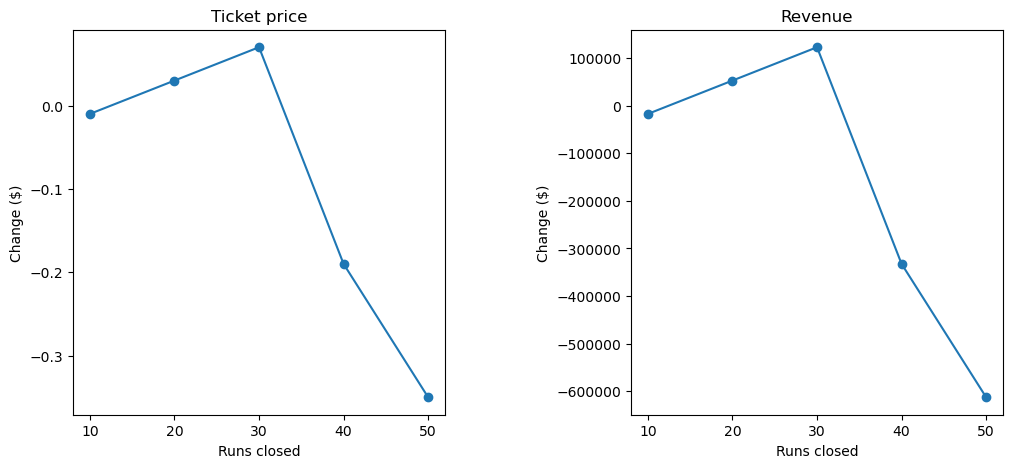

In [473]:
#Code task 3#
#Create two plots, side by side, for the predicted ticket price change (delta) for each
#condition (number of runs closed) in the scenario and the associated predicted revenue
#change on the assumption that each of the expected visitors buys 5 tickets
#There are two things to do here:
#1 - use a list comprehension to create a list of the number of runs closed from `runs_delta`
#2 - use a list comprehension to create a list of predicted revenue changes from `price_deltas`
runs_delta = list(range(-10, -51, -10))
runs_closed = [-1 * delta for delta in runs_delta] #1
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(wspace=0.5)
ax[0].plot(runs_closed, price_deltas, 'o-')
ax[0].set(xlabel='Runs closed', ylabel='Change ($)', title='Ticket price')
revenue_deltas = [5 * expected_visitors * delta for delta in price_deltas] #2
ax[1].plot(runs_closed, revenue_deltas, 'o-')
ax[1].set(xlabel='Runs closed', ylabel='Change ($)', title='Revenue');
plt.show()

The model says closing one run makes no difference. Closing 2 and 3 successively reduces support for ticket price and so revenue. If Big Mountain closes down 3 runs, it seems they may as well close down 4 or 5 as there's no further loss in ticket price. Increasing the closures down to 6 or more leads to a large drop. 

### 5.9.2 Scenario 2<a id='5.9.2_Scenario_2'></a>

In this scenario, Big Mountain is adding a run, increasing the vertical drop by 150 feet, and installing an additional chair lift.

In [474]:
#Code task 4#
#Call `predict_increase` with a list of the features 'Runs', 'vertical_drop', and 'total_chairs'
#and associated deltas of 1, 150, and 1
ticket2_increase = predict_increase(['runs', 'vertical_drop', 'total_chairs'], [1, 150, 1], X_bm, model)
revenue2_increase = 5 * expected_visitors * ticket2_increase


In [475]:
print(f'This scenario increases support for ticket price by ${ticket2_increase:.2f}')
print(f'Over the season, this could be expected to amount to ${revenue2_increase:.0f}')

This scenario increases support for ticket price by $2.09
Over the season, this could be expected to amount to $3657500


### 5.9.3 Scenario 3<a id='5.9.3_Scenario_3'></a>

In this scenario, you are repeating the previous one but adding 2 acres of snow making.

In [476]:
#Code task 5#
#Repeat scenario 2 conditions, but add an increase of 2 to `Snow Making_ac`
ticket3_increase = predict_increase(['runs', 'vertical_drop', 'total_chairs', 'snow_making_ac'], [1, 150, 1, 2], X_bm, model)
revenue3_increase = 5 * expected_visitors * ticket3_increase

In [477]:
print(f'This scenario increases support for ticket price by ${ticket3_increase:.2f}')
print(f'Over the season, this could be expected to amount to ${revenue3_increase:.0f}')

This scenario increases support for ticket price by $2.09
Over the season, this could be expected to amount to $3657500


Such a small increase in the snow making area makes no difference!

### 5.9.4 Scenario 4<a id='5.9.4_Scenario_4'></a>

This scenario calls for increasing the longest run by .2 miles and guaranteeing its snow coverage by adding 4 acres of snow making capability.

In [478]:
#Code task 6#
#Predict the increase from adding 0.2 miles to `LongestRun_mi` and 4 to `Snow Making_ac`
predict_increase(['longestrun_mi','snow_making_ac'], [0.2, 2], X_bm, model)

0.0

No difference whatsoever. Although the longest run feature was used in the linear model, the random forest model (the one we chose because of its better performance) only has longest run way down in the feature importance list. 

## 5.10 Summary<a id='5.10_Summary'></a>

**Q: 1** Write a summary of the results of modeling these scenarios. Start by starting the current position; how much does Big Mountain currently charge? What does your modelling suggest for a ticket price that could be supported in the marketplace by Big Mountain's facilities? How would you approach suggesting such a change to the business leadership? Discuss the additional operating cost of the new chair lift per ticket (on the basis of each visitor on average buying 5 day tickets) in the context of raising prices to cover this. For future improvements, state which, if any, of the modeled scenarios you'd recommend for further consideration. Suggest how the business might test, and progress, with any run closures.

**A: 1** Big Mountain currently charges 81 per ticket. Our modeling suggests the resort could reasonably support a higher ticket price of around 94.51, especially when considering upgrades such as adding an extra run, increasing vertical drop by 150 feet, and installing an additional chair lift. Given that the new chair lift has additional operating costs, raising ticket prices modestly (assuming each visitor buys around 5 tickets) could offset these expenses while boosting overall revenue. Before proposing these changes, I’d recommend engaging business leadership and stakeholders by clearly presenting the predicted customer benefits and added value from these enhancements. For run closures, the business should carefully test visitor reactions through targeted pilot closures or customer surveys, ensuring minimal negative impact on customer satisfaction and revenue.

## 5.11 Further work<a id='5.11_Further_work'></a>

**Q: 2** What next? Highlight any deficiencies in the data that hampered or limited this work. The only price data in our dataset were ticket prices. You were provided with information about the additional operating cost of the new chair lift, but what other cost information would be useful? Big Mountain was already fairly high on some of the league charts of facilities offered, but why was its modeled price so much higher than its current price? Would this mismatch come as a surprise to the business executives? How would you find out? Assuming the business leaders felt this model was useful, how would the business make use of it? Would you expect them to come to you every time they wanted to test a new combination of parameters in a scenario? We hope you would have better things to do, so how might this model be made available for business analysts to use and explore?

limited data beyond ticket prices present certain challenges like absence of operating cost to include staffing, maintenance, utlity etc which could better inform pricing decisions. The modeled price of 94.51 exceedes big mt current ticket price of 81 potentially reflecting untapped pricing power. To max the usefulness of this model it could be recommended to be integrated into an intuitive or interactive dashboard made accessible by analysts. This would allow business to independently explore pricing scenarios